In [64]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import control as ctl
import numpy as np
import pandas as pd

In [65]:
T = 0.100
s = ctl.TransferFunction.s

In [66]:
G = 0.0218891424389763*s/(1.0*s - 3.592525994444)
C = (5.0*s**2 + 501.0*s + 100.0)/(0.005*s**2 + 0.01*s)

G_feedback = ctl.feedback(G*C, 1)
G_feedback

TransferFunction(array([ 0.10944571, 10.96646036,  2.18891424,  0.        ]), array([ 0.11444571, 10.95849773,  2.15298898,  0.        ]))

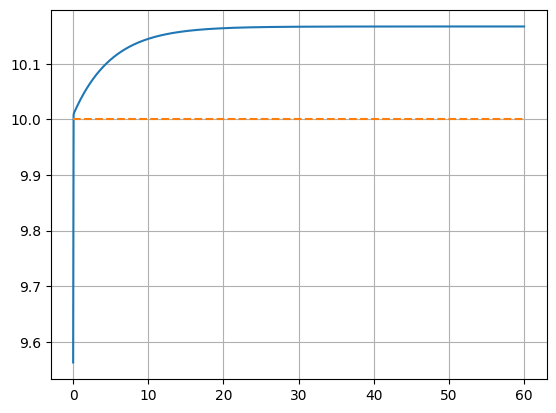

In [67]:
sp = 10

tData = np.linspace(0, 60, 1000)
uData = [sp for i in tData]
time, response = ctl.forced_response(G_feedback, T=tData, U=uData)

plt.plot(time, response)
plt.plot(time, [sp for i in time], '--')
plt.grid()

# TRANSFORMADA Z
Primeiro vamos aplicar a transformada $Z$ na planta com o método $zoh$ (que é adequado para a planta) e aplicar também uma outra transformada $z$ no controlador, com outro método de transformação mais adequado, para depois fechar a malha. As possíveis transformadas são:

- $zoh$ (zero-order hold on the inputs)
- $foh$ (linear interpolation of inputs)
- $tustin$ (bilinear approximation)
- $impulse$ (impulse-variant discretization)
- $matched$ (matched pole-zero method (for SISO systems only))

In [68]:
G_z = ctl.c2d(G, T, method='zoh')
G_z

TransferFunction(array([ 0.02188914, -0.02188914]), array([ 1.        , -1.43225854]), 0.1)

In [69]:
C_z = ctl.c2d(C, T, method='tustin')
C_z

TransferFunction(array([ 5509.09090909, -1727.27272727, -3600.        ]), array([ 1.        , -1.81818182,  0.81818182]), 0.1)

In [70]:
G_z_feedback = ctl.feedback(G_z*C_z, 1)
G_z_feedback

TransferFunction(array([ 120.58927562, -158.39779438,  -40.99239402,   78.80091278]), array([ 121.58927562, -161.64823474,  -37.57010576,   77.62906488]), 0.1)

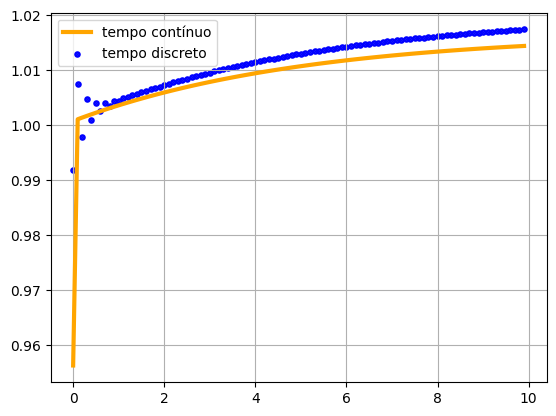

In [71]:
tLimits = np.arange(0, 10, T)

time, response = ctl.step_response(G_feedback, T=tLimits)
plt.plot(time, response, color='orange', linewidth=3, label='tempo contínuo')

time, response = ctl.step_response(G_z_feedback, T=tLimits)
plt.scatter(time, response, color='blue', linewidth=3, label='tempo discreto', s=3)

plt.legend()
plt.grid()
plt.show()

# COMPARANDO A RESPOSTA DO CONTROLADOR

- Passando os vetores dos coeficientes do numerador e denominador para uma string que é a própria função do sistema discretizada

In [72]:
num, den = ctl.tfdata(C_z)
num = np.squeeze(num)
den = np.squeeze(den)

num = num/den[0]
den = den/den[0]

if type(num) == np.float64:
    num = np.array([num])

print(num)
print(den)

[ 5509.09090909 -1727.27272727 -3600.        ]
[ 1.         -1.81818182  0.81818182]


- Printando a saída de forma a ser entendida por uma máquina de baixo nível

In [73]:
out = ''

for i in range(0, len(num)):
    out += f'{num[i]}*X_n{i} + '

for i in range(1, len(den)):
    out += f'+ {-1*den[i]}*Y_n{i}'

out = out.replace('X_n0', 'X_n').replace('+ +', '+').replace('+ -', '-')
print(out + ';')

5509.090909090909*X_n -1727.272727272728*X_n1 -3600.000000000032*X_n2 + 1.8181818181818181*Y_n1-0.8181818181818181*Y_n2;


- Resposta do controlador em feedback

In [74]:
Y_n1 = Y_n2 = Y_n3 = Y_n4 = 0
X_n1 = X_n2 = X_n3 = X_n4 = 0

def computeController(inputValue, setpoint):
    global Y_n1, Y_n2, Y_n3, Y_n4
    global X_n1, X_n2, X_n3, X_n4

    X_n =  setpoint - inputValue
    Y_n = eval(out)

    X_n4 = X_n3
    X_n3 = X_n2
    X_n2 = X_n1
    X_n1 = X_n

    Y_n4 = Y_n3
    Y_n3 = Y_n2
    Y_n2 = Y_n1
    Y_n1 = Y_n
    return Y_n

- Comparando os dados contínuo e digital de forma gráfica através de um step

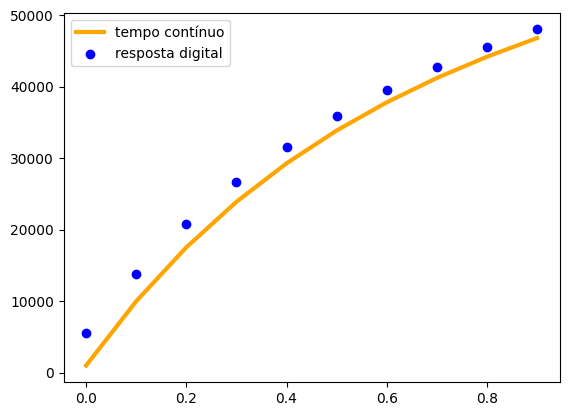

In [75]:
tLimits = np.arange(0, 1, T)

time, response = ctl.step_response(C, T=tLimits)
plt.plot(time, response, color='orange', linewidth=3, label='tempo contínuo')

Y_n1 = Y_n2 = Y_n3 = Y_n4 = 0
X_n1 = X_n2 = X_n3 = Y_n4 = 0

response = [computeController(1, 2) for i in tLimits] # degrau (erro 1 é a entrada)
plt.scatter(time, response, color='blue', label='resposta digital')

plt.legend()
plt.show()

# TESTANDO A RESPOSTA
- Se o erro é positivo, o controlador atua aumentando a saída do sistema

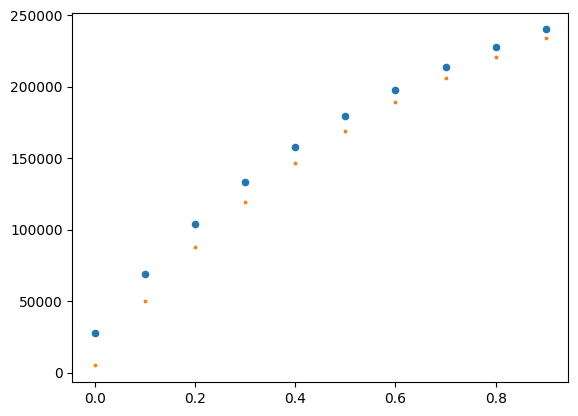

In [76]:
inputValue = 5
setpoint   = 10

Y_n1 = Y_n2 = Y_n3 = 0
X_n1 = X_n2 = X_n3 = 0

time     = tLimits
response = [computeController(inputValue, setpoint) for i in time] 
plt.scatter(time, response, s=20)

time, response = ctl.forced_response(C, T=time, U=[setpoint - inputValue for i in time])
plt.scatter(time, response, s=3)

- Se o erro é negativo, o controlador atua diminuindo a saída do sistema

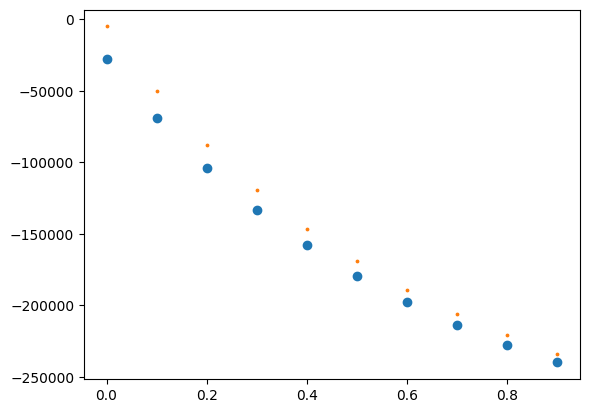

In [77]:
inputValue = 15
setpoint   = 10

Y_n1 = Y_n2 = Y_n3 = 0
X_n1 = X_n2 = X_n3 = 0

time     = tLimits
response = [computeController(inputValue, setpoint) for i in time] 
plt.scatter(time, response)

time, response = ctl.forced_response(C, T=time, U=[setpoint - inputValue for i in time])
plt.scatter(time, response, s=3)

- Se o erro é zero, o não atua e mantém a saída fixa

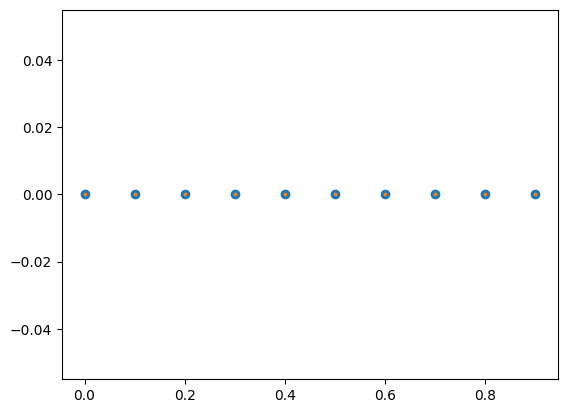

In [78]:
inputValue = 10
setpoint   = 10

Y_n1 = Y_n2 = Y_n3 = 0
X_n1 = X_n2 = X_n3 = 0

time     = tLimits
response = [computeController(inputValue, setpoint) for i in time] 
plt.scatter(time, response)

time, response = ctl.forced_response(C, T=time, U=[setpoint - inputValue for i in time])
plt.scatter(time, response, s=3)